In [2]:
import csv, json 
import os.path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import librosa
import librosa.display
import IPython.display as ipd
import math

# use LateX fonts
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


# Initialize constants

In [3]:
#session_nums = [session_num for session_num in range(300, 493) if session_num not in [342, 394, 398, 460, 443]]
AUDIO_FEATURES = ['f0_median', 'f0_mean', 'f0_range', 'rmse_median', 'rmse_mean', 'zcr_median', 'zcr_mean', 'ber_median', 'ber_mean']
PATH_TO_AUDIO = "interviews/"
FILE_NAME_SUFFIX = "_AUDIO_SLICED_30.0s.wav"
PHQ_CSV_FILE = "participants_info/phq_scores.csv"
PARTICIPANTS_INFO = {}
PARTICIPANTS_INFO_EXIST_ON_DISK = False
SAMPLING_RATE = 16000
SPLIT_FREQUENCY = 500

FRAME_SIZE = 512
HOP_LENGTH = 256

# check if feature extraction results already exist on disk

In [74]:
if os.path.exists('extracted_feature_results/results.json'):
    PARTICIPANTS_INFO_EXIST_ON_DISK = True
    with open('extracted_feature_results/results.json', 'r') as jsonFile:
        PARTICIPANTS_INFO = json.load(jsonFile)
    print(PARTICIPANTS_INFO_EXIST_ON_DISK)
   

True


[389.38687  343.27295  352.43387  ... 925.726     84.235344 233.20187 ]
2553.5251


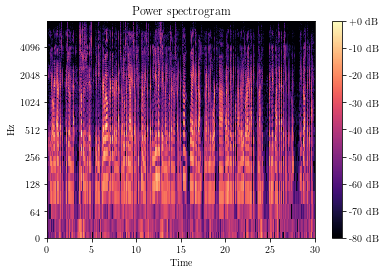

In [88]:
audio, sr = librosa.load("interviews/331_AUDIO_SLICED_30.0s.wav", sr=SAMPLING_RATE)
S_interview = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
ber_interview = band_energy_ratio(S_interview, SPLIT_FREQUENCY, SAMPLING_RATE)
print(ber_interview)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_interview,ref=np.max),y_axis='log', x_axis='time', ax=ax, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")


print(np.mean(ber_interview))

# Loading participants phq scores

In [6]:
def createParticipantInfoFromCsv(csv_file: str) -> dict:
    outer_dict = {}
    with open(csv_file) as csvFile:
        csv_reader = csv.reader(csvFile, delimiter=',')
        line_count = 0
        for row in csv_reader:
            line_count += 1
            #or row[0] == '387'
            if line_count == 1:
                continue
            inner_dict = {}
            if row[1] == "1":
                inner_dict.update({"depressed": "yes"})
            else:
                inner_dict.update({"depressed": "no"})
            inner_dict.update({"phq_score": row[2]})
            if row[3] == "1":
                inner_dict.update({"gender": "male"})
            else:
                inner_dict.update({"gender": "female"})
            outer_dict[row[0]] = inner_dict
        
    return outer_dict

# store info in dict

In [7]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    PARTICIPANTS_INFO = createParticipantInfoFromCsv(PHQ_CSV_FILE)

# Loading audio Files

In [8]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    for k, v in PARTICIPANTS_INFO.items():
        loaded_audio, _ = librosa.load(f"{PATH_TO_AUDIO}{k}{FILE_NAME_SUFFIX}", sr=SAMPLING_RATE, offset=20.0)
        v.update({"loaded_audio_30s": loaded_audio})
        print(f"loaded audio file for participant {k}!")
    print("loaded all audio files with librosa!")

# functions for calculating band energy ratio

In [9]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [10]:
# map split frequency to frequency bin
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

# calculate audio features

In [11]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    for k, v in PARTICIPANTS_INFO.items():
        rmse_audio = librosa.feature.rms(v['loaded_audio_30s'], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        rmse_median = np.median(rmse_audio)
        rmse_mean = np.mean(rmse_audio)
        zcr_audio = librosa.feature.zero_crossing_rate(v['loaded_audio_30s'], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        zcr_median = np.median(zcr_audio)
        zcr_mean = np.mean(zcr_audio)
        f0, _, _ = librosa.pyin(v['loaded_audio_30s'], fmin=50, fmax=500, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)
        f0_no_nans = f0[~np.isnan(f0)]
        f0_median = np.median(f0_no_nans)
        f0_mean = np.mean(f0_no_nans)
        f0_range = np.max(f0_no_nans) - np.min(f0_no_nans)
        S_interview = librosa.stft(v['loaded_audio_30s'], n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
        ber_interview = band_energy_ratio(S_interview, SPLIT_FREQUENCY, SAMPLING_RATE)
        ber_median = np.median(ber_interview)
        ber_mean = np.mean(ber_interview)

        v.update({"f0_median": f0_median})
        v.update({"f0_mean": f0_mean})
        v.update({"f0_range": f0_range})
        v.update({"zcr_median": zcr_median})
        v.update({"zcr_mean": zcr_mean})
        v.update({"rmse_median": rmse_median})
        v.update({"rmse_mean": rmse_mean})
        v.update({"ber_median": ber_median})
        v.update({"ber_mean": ber_mean})
        print(f"calculated audio features for participant {k}!")
    print("calculated all audio features with librosa!")

# store feature results on disk

In [69]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    updated_participant_info = PARTICIPANTS_INFO.copy()
    for v in updated_participant_info.values():
        if 'loaded_audio_30s' in v:
            del v['loaded_audio_30s']
        for audio_feat in AUDIO_FEATURES:
            v[audio_feat] = float(v[audio_feat])
    with open('extracted_feature_results/results.json', 'w') as jsonFile:
        json.dump(updated_participant_info, jsonFile)

# compute statistics

In [75]:
group_stats = {'male': {
    'x': [],
    'x_ber_mean': [],
    'x_ber_median': [],
    'zcr_median': [],
    'zcr_mean': [],
    'rmse_median': [],
    'rmse_mean': [],
    'f0_median': [],
    'f0_mean': [],
    'f0_range': [],
    'ber_median': [],
    'ber_mean': [],
    'spearman_coeffs': {} # contains coeffs for every calculated audio feature
}, 'female': {
    'x': [],
    'x_ber_mean': [],
    'x_ber_median': [],
    'zcr_median': [],
    'zcr_mean': [],
    'rmse_median': [],
    'rmse_mean': [],
    'f0_median': [],
    'f0_mean': [],
    'f0_range': [],
    'ber_median': [],
    'ber_mean': [],
    'spearman_coeffs': {} # contains coeffs for every calculated audio feature
}}

depressed = 0
healthy = 0
males = 0
females = 0

for v in PARTICIPANTS_INFO.values():
    if v['depressed'] == "yes":
        depressed += 1
    else:
        healthy += 1
    if v['gender'] == 'male':
        males += 1
    else:
        females += 1

for v in PARTICIPANTS_INFO.values():
    if v['gender'] == 'male':
        group_stats['male']['x'].append(int(v['phq_score']))
        for audio_feat in AUDIO_FEATURES:
            group_stats['male'][audio_feat].append(v[audio_feat])

    elif v['gender'] == 'female':
        group_stats['female']['x'].append(int(v['phq_score']))
        for audio_feat in AUDIO_FEATURES:
            group_stats['female'][audio_feat].append(v[audio_feat])


# spearman correlation
# scipy spearman returns correlation and p-value
# pvalue: The p-value for a hypothesis test whose null hypotheisis is that two sets of data are uncorrelated. See alternative above for alternative hypotheses. pvalue has the same shape as correlation.

# males
for k, v in group_stats['male'].items():
    if k not in ['x', 'spearman_coeffs', 'x_ber_mean', 'x_ber_median']:
        corr_sp = stats.spearmanr(group_stats['male']['x'], group_stats['male'][k])
        group_stats['male']['spearman_coeffs'][k] = corr_sp

# females
for k, v in group_stats['female'].items():
    if k not in ['x', 'spearman_coeffs', 'x_ber_mean', 'x_ber_median']:
        corr_sp = stats.spearmanr(group_stats['female']['x'], group_stats['female'][k])
        group_stats['female']['spearman_coeffs'][k] = corr_sp
        
print(len(group_stats['male']['zcr_median']))
print(group_stats['female']['spearman_coeffs'])


101
{'zcr_median': SpearmanrResult(correlation=-0.15126720909290586, pvalue=0.16193849619244485), 'zcr_mean': SpearmanrResult(correlation=0.03412064752269331, pvalue=0.7537151612353294), 'rmse_median': SpearmanrResult(correlation=-0.14180087176404418, pvalue=0.19015135424246718), 'rmse_mean': SpearmanrResult(correlation=-0.0857787433860092, pvalue=0.42954170734315855), 'f0_median': SpearmanrResult(correlation=-0.03693929848069748, pvalue=0.7340979944891189), 'f0_mean': SpearmanrResult(correlation=-0.07016931512015541, pvalue=0.5183919667960737), 'f0_range': SpearmanrResult(correlation=-0.13685666761192072, pvalue=0.2062272334749501), 'ber_median': SpearmanrResult(correlation=0.0008407888761466915, pvalue=0.9938332700947405), 'ber_mean': SpearmanrResult(correlation=-0.04419625005484131, pvalue=0.6843962365663911)}


# plot data

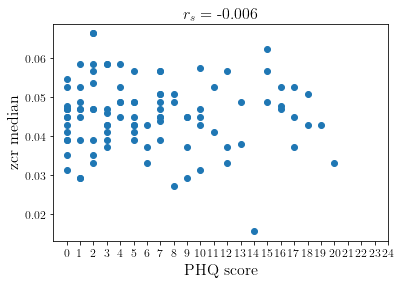

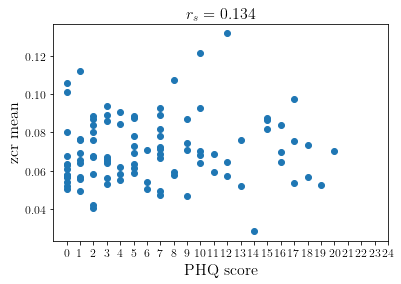

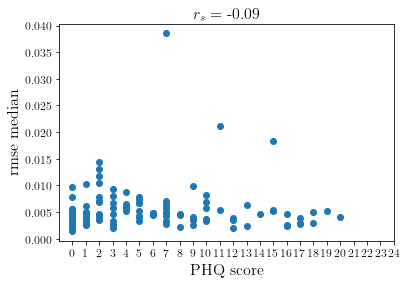

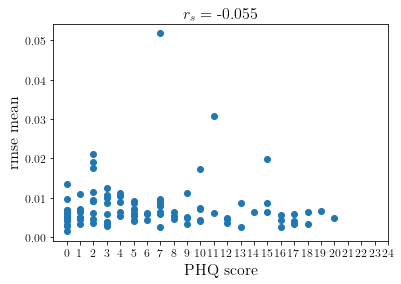

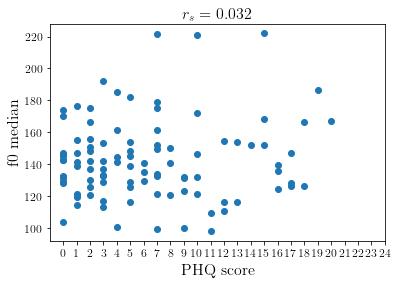

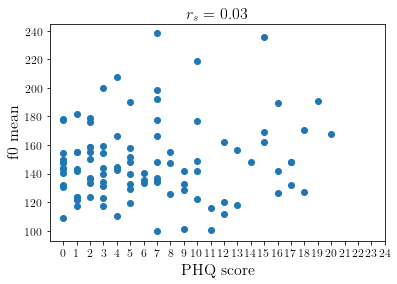

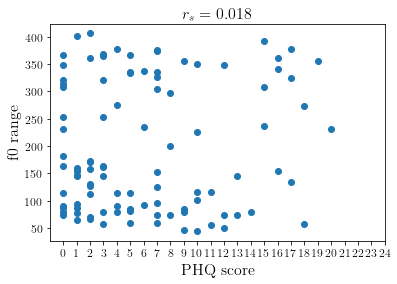

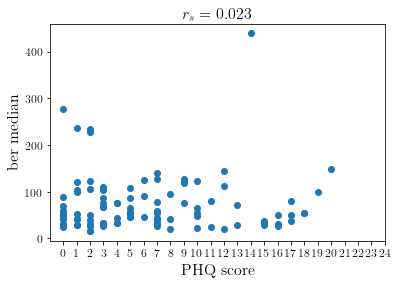

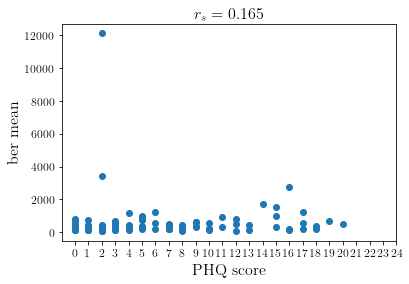

-------------------------------------------------------------------


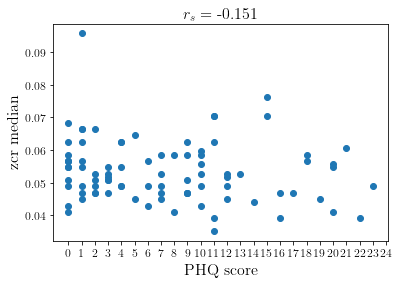

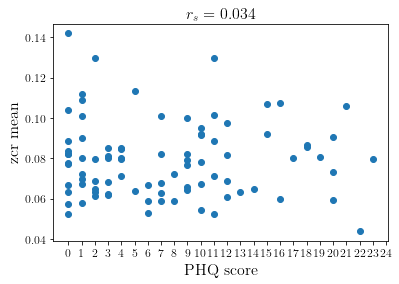

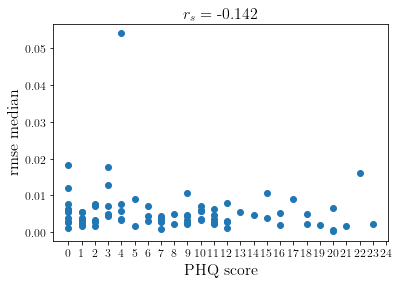

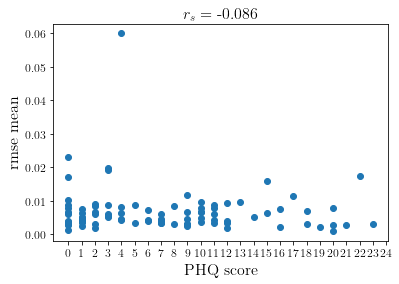

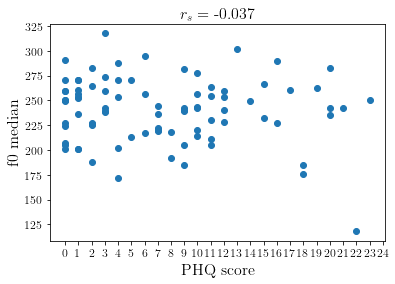

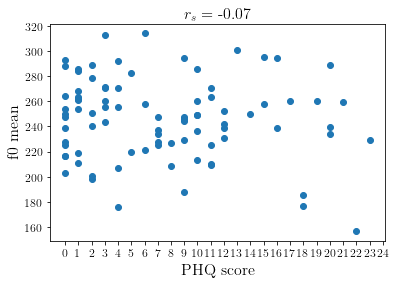

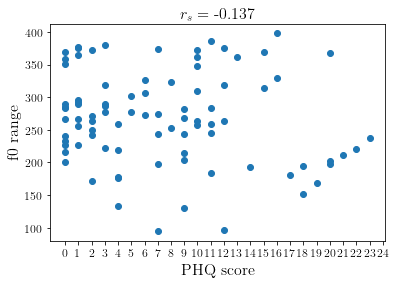

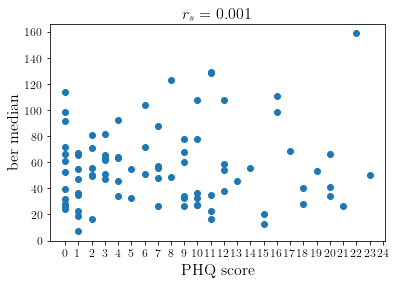

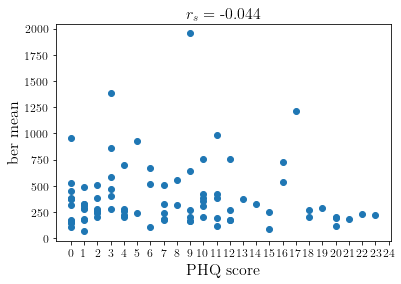

In [83]:
def plot_scatter(x, y, x_label, y_label, plot_title, x_ticks=None, axis_font_size=12, ticks_font_size=11):
    #plt.figure(figsize=(15, 6))
    plt.scatter(x, y)
    plt.xlabel(x_label, fontsize=axis_font_size)
    plt.ylabel(y_label, fontsize=axis_font_size)
    plt.xticks(x_ticks)
    #plt.grid(True)
    plt.xticks(fontsize=ticks_font_size)
    plt.yticks(fontsize=ticks_font_size)
    plt.title(plot_title, fontsize=axis_font_size)
    #plt.text(21, 0.06, 'matplotlib')
    #plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
    plt.show()


# plot for males
for k, v in group_stats['male'].items():
    if k not in ['x', 'spearman_coeffs', 'x_ber_mean', 'x_ber_median']:
        spearman = group_stats['male']['spearman_coeffs'][k][0]
        plot_scatter(group_stats['male']['x'], 
                 v, 
                 'PHQ score',
                 k.replace('_', ' '),
                 r'$r_{s}=$' + f" {round(spearman, 3)}", 
                 x_ticks=range(0, 25),
                 axis_font_size=16,
                 ticks_font_size=12)

        
print("-------------------------------------------------------------------")


# plot for females
for k, v in group_stats['female'].items():
    if k not in ['x', 'spearman_coeffs', 'x_ber_mean', 'x_ber_median']:
        spearman = group_stats['female']['spearman_coeffs'][k][0]
        plot_scatter(group_stats['female']['x'], 
                 v, 
                 'PHQ score',
                 k.replace('_', ' '),
                 r'$r_{s}=$' + f" {round(spearman, 3)}",  
                 x_ticks=range(0, 25),
                 axis_font_size=16,
                 ticks_font_size=12)        
        
        
        
        
# plt.figure(figsize=(15, 50))
# ax = plt.subplot(9, 1, 1)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)
# plt.scatter(x, y_zcr_median)
# plt.xlabel("PHQ score", fontsize=16)
# plt.xticks(range(0, 25))
# plt.ylabel("Zero crossing rate (median)", fontsize=16)
# plt.title(f"Correlation = {r_zcr_median}")
# plt.vlines(9.5, min(y_zcr_median), max(y_zcr_median), linestyles='dashed')

# plt.subplot(9, 1, 2)
# plt.scatter(x, y_zcr_mean)
# plt.xlabel("PHQ score", fontsize=16)
# plt.xticks(range(0, 25))
# plt.ylabel("Zero crossing rate (mean)", fontsize=16)
# plt.title(f"Correlation = {r_zcr_mean}")
# plt.vlines(9.5, min(y_zcr_mean), max(y_zcr_mean), linestyles='dashed')


